# Double Delay Line Implementation

With the addition of the air absorption filter and of the asphalt reflection filter, in the reflected path the signal goes through the cascade of a LTV (Linear Time Varying) and two LTI (Linear Time Invariant) filters. In fact, the asphalt reflection, due to its dependency on the angle of incidence of the sound wave, is LTV, while the air absorption filters are LTI (their coefficients only depend on frequency, and not on the relative positions of the source and the receiver). The block diagram of the signal paths is the following:

<img src="Delay_Lines.png">

Due to this configuration, we cannot swap the absorption filters (LTI) and the reflection filter (LTV), therefore we need to implement the schematic as it is drawn. In order to do so, we need to use two connected delay lines. One possible implementation of the system is depicted by the following block diagram:

<img src = "delay_line_implementation.png">

The upper path represents the direct sound path, and the lower one the reflected sound path. The second delay line is synchronized with the first one in the sense that the $r_r$ and $w_2$ operations are performed at the same computation step. 

In [1]:
import numpy as np
import scipy.signal
import scipy.io
from scipy.io import wavfile
import matplotlib.pyplot as plt
import math


# Uncomment to make Gif
# import imageio
# import os
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from IPython import display
# from pathlib import Path


#### Auxiliary Functions for Delay Line
These functions are used to set the initial delay of the delay line, and to compute the fractional delay filters that will be needed in order to perform the interpolated reads

In [2]:
# Windowed Sinc Function
sinc_samples = 81
sinc_window = np.hanning(sinc_samples)

def set_delay(M):
    global rptr
    rptr = wptr - M
    if (rptr < 0):
        rptr += N

def frac_delay_sinc(delay):
    global sinc_samples
    global sinc_window

    return sinc_window * np.sinc(np.arange(0,sinc_samples) - (sinc_samples - 1) / 2 - delay)

def frac_delay_lagrange(N, delay):
    n = np.arange(0,N+1)
    h = np.ones(N+1)

    for k in range(0,N+1):
        # Find index n != k
        index = []
        for j in range(0,N+1):
            if j != k:
                index.append(j)
        
        h[index] = h[index] * (delay - k) / (n[index] - k)

    return h

#### Air Absorption Filter
These functions are used to compute the coefficients of the air absoprtion filter, given some parameters of the acoustic scene under analysis:
- T: temperature of the environment in Kelvin degrees
- hum_rel: relative humidity expressed as a percentage value
- p_s: atmospheric pressure expressed in atm (STILL TO BE CHECKED)

When applying this filter, we will consider that the sounds propagates as plane waves along straight lines. The pressure, then, varies according to the relation

$p = p_0 e^{-\alpha d / 2}$

where $d$ denotes the distance between the source and the receiver.

In [3]:
def compute_air_absorption_coeffs(T, p_s, rel_humidity, F):
    ## Computes the air absorption coefficients alpha:
    #   T: temperature in Kelvin
    #   p_s: pressure in atm
    #   rel_humidity: relative humidity as a percentage
    #   F: frequencies to compute the coefficients for

    T_0 = 293.15        # Absolute atmospheric temperature
    p_s0 = 1            # Atmospheric Pressure in atm

    Csat = -6.8346 * (T_0 / T) ** 1.261 + 4.6151
    psat = 10 ** Csat
    H = H = psat * rel_humidity * p_s0 / p_s
    F_r0 = (p_s / p_s0) * (24 + 4.04 * 10**4 * H * (0.02 + H) / (0.391 + H))
    F_rN = (p_s / p_s0) * (T_0 / T)**(1/2) * ( 9 + 280 * H * np.exp(-4.17 * ((T_0 / T)**(1/3) - 1)))
    return 20 / np.log(10) * F ** 2 * (((1.84*10**(-11))/((T_0 / T)**(1/2) * p_s / p_s0)) +
            (T_0 / T)**(5/2) * ( (0.1068 * np.exp(-3352/T) * F_rN) / (F**2 + F_rN**2) +
            (0.01278*np.exp(-2239.1 / T) * F_r0) / (F**2 + F_r0**2)))

def compute_air_absorption_coeffs2(T, ps, rh, f):
    T0 = 293.15
    T01 = 273.16
    ps0 = 1

    Csat = -6.8346 * math.pow(T01 / T, 1.261) + 4.6151
    rhosat = math.pow(10, Csat)
    H = rhosat * rh * ps0 / ps

    frn = (ps / ps0) * math.pow(T0 / T, 0.5) * (
            9 + 280 * H * math.exp(-4.17 * (math.pow(T0 / T, 1/3.) - 1)))

    fro = (ps / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

    alpha = f * f * (
        1.84e-11 / ( math.pow(T0 / T, 0.5) * ps / ps0 )
        + math.pow(T / T0, -2.5)
        * (
            0.10680 * math.exp(-3352 / T) * frn / (f * f + frn * frn)
            + 0.01278 * math.exp(-2239.1 / T) * fro / (f * f + fro * fro)
            )
        )

    return 20 * alpha / math.log(10)

def compute_air_absorption_filter(F, abs_coeffs, numtaps):
    norm_freqs = F / max(F)
    filt_coeffs = scipy.signal.firwin2(numtaps, norm_freqs, abs_coeffs)
    return filt_coeffs


With these functions we are using a FIR filter to take into account the air absorption described by the coefficients $\alpha$. Note, however, that the actual attenuation in the sound pressure level depends on the distance $d$ between the source and the receiver. Therefore, to use the FIR implementation, we need to compute a new filter every time the distance changes. This will have a strong impact on the computational complexity of the system $\longrightarrow$ **we need to optimize this**

In [4]:
# Parameters
T_0 = 293.15        # Absolute atmospheric temperature
T_celsius = 20      # Actual temperature
T = T_celsius + 273.15

p_s0 = 1            # Atmospheric Pressure in atm
p_s = 1             # Actual pressure in atm

hrar = 50           # Relative Humidity in %
F = np.linspace(0, 11000, num=50)

numtaps_airabs = 21
alpha = compute_air_absorption_coeffs(T, p_s, hrar, F)
filt_coeffs = compute_air_absorption_filter(F, alpha, numtaps_airabs)
alpha2 = compute_air_absorption_coeffs2(T, p_s, hrar, F)


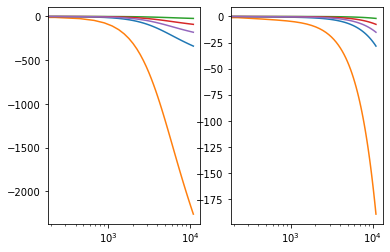

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.semilogx(F, -150 * 20 / np.log(10) * (alpha))
plt.semilogx(F, -1000 * 20 / np.log(10) * (alpha))
plt.semilogx(F, -10 * 20 / np.log(10) * (alpha))
plt.semilogx(F, -40 * 20 / np.log(10) * (alpha))
plt.semilogx(F, -80 * 20 / np.log(10) * (alpha))

plt.subplot(1,2,2)
plt.semilogx(F, -150 * alpha2)
plt.semilogx(F, -1000 * alpha2)
plt.semilogx(F, -10 * alpha2)
plt.semilogx(F, -40 * alpha2)
plt.semilogx(F, -80 * alpha2)

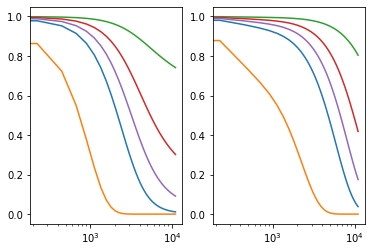

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.semilogx(F, 10 ** (-alpha * 150 / 20))
plt.semilogx(F, 10 ** (-alpha * 1000 / 20))
plt.semilogx(F, 10 ** (-alpha * 10 / 20))
plt.semilogx(F, 10 ** (-alpha * 40 / 20))
plt.semilogx(F, 10 ** (-alpha * 80 / 20))

plt.subplot(1,2,2)
plt.semilogx(F, 10 ** (-alpha2 * 150 / 20))
plt.semilogx(F, 10 ** (-alpha2 * 1000 / 20))
plt.semilogx(F, 10 ** (-alpha2 * 10 / 20))
plt.semilogx(F, 10 ** (-alpha2 * 40 / 20))
plt.semilogx(F, 10 ** (-alpha2 * 80 / 20))

#### Attenuation of Sound with Distance 
Auxiliary function that computes the attenuation of sound as it propagates far from the source. The source is considered as a point source

In [7]:
def sound_attenuation_distance(d):
    return 1 / (4 * np.pi * d)

#### Direct Path Delay Line Implementation

In [8]:
fs = 8000
# Straight Trajectory between starting and end point
P1 = np.array([3,20])
P2 = np.array([3, -5])
P3 = np.array([0,0])

v = 10   # speed of sound source

# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj ** 2 + dline ** 2)

# Compute time delay in number of samples
c = 343
tau_init = dinit / c

M_init = tau_init * fs
print(M_init)

delays_sec = []
delays_smp = []
delays_sec.append(tau_init)

# Define delay line
N = 1024
A = np.zeros(N)


rptr = 0
wptr = 0
M = np.floor(M_init)    # Define initial delay
delays_smp.append(M)

def delay_line(x):
    global rptr
    global wptr
    global A
    global v
    global dproj
    global c
    global fs
    global delays_smp
    
    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    # Linear Interpolation
    y1 = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    # Sinc Interpolation -> Windowed Sinc function
    # h_sinc = frac_delay_sinc(a)
    
    # y2 = 0
    # for i in range(0, sinc_samples):
    #     y2 = y2 + h_sinc[i]*A[np.mod(rpi + i - math.floor(sinc_samples/2), len(A))]
    
    # # Lagrange Interpolation
    # order = 5
    # h_lagrange = frac_delay_lagrange(order, a)
    # y3 = 0

    # for i in range(0, len(h_lagrange)):
    #     y3 = y3 + h_lagrange[i] * A[np.mod(rpi + i, len(A))]

    # Update delay
    dproj -= v / fs
    
    d2 = dline2 + dproj ** 2
    d = np.sqrt(d2)
    tau = d / c
    M = tau * fs
    rptr = wptr - M

    # For the plots, remove later
    delays_sec.append(tau)
    delays_smp.append(M)

    if (rptr < 0):
        rptr += N
    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    # return y1, y2, y3, d
    return y1, d

set_delay(M)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
# signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
signal = np.zeros_like(time)
signal[::500] = 1

aa = np.zeros_like(signal)
bb = np.zeros_like(signal)
# cc = np.zeros_like(signal)

# Direct Path Implementation
for i in range(0, len(signal)):
    # Delay passage
    [sample, d] = delay_line(signal[i])

    # Attenuation due to distance
    att = sound_attenuation_distance(d)
    aa[i] =  att * sample

    # Attenuation due to air absorption

    alpha = compute_air_absorption_coeffs(T, p_s, hrar, F)
    alpha = 10 ** (-alpha * d / 20)     # Convert coeffs in dB to linear scale
    filt_coeffs = compute_air_absorption_filter(F, alpha, numtaps_airabs)
    
    sample_eval = 0
    for ii in range(numtaps_airabs):
        sample_eval = sample_eval + aa[i - ii] * filt_coeffs[ii]
    
    bb[i] = sample_eval


471.6909251581734


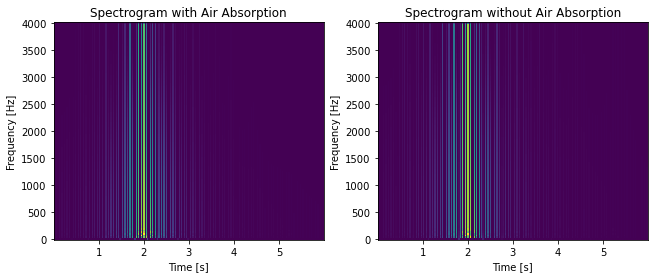

In [9]:
plt.figure()
plt.subplot(1,2,1)
ff, tt, Sxx = scipy.signal.spectrogram(bb, fs)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram with Air Absorption')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.subplot(1,2,2)
ff, tt, Sxx = scipy.signal.spectrogram(aa, fs)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram without Air Absorption')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.subplots_adjust(left=0.125, right=1.5)

plt.show()

wavfile.write('prova.wav', fs, bb)

#### Double Delay Line Implementation

Auxiliary functions to compute parameters needed to design the asphalt reflection filter

In [10]:
def compute_air_impedance(T, p = 1, c = None):
    ## Computes air impedance given:
    #   T: temperature in Kelvin
    #   p: atmospheric pressure in atm
    #   c: speed of sound in air, at temperature T
    if c == None:
        c = compute_speed_sound(T)
    p = p * 101325          # Convert atm to Pascal
    R_spec = 287.058
    return p / (R_spec * T) * c

def compute_speed_sound(T):
    ## Computes speed of sound in air at temperature T:
    #   T: temperature expressed in Kelvin
    import numpy as np
    return 331.3 * np.sqrt(T / 273.15)


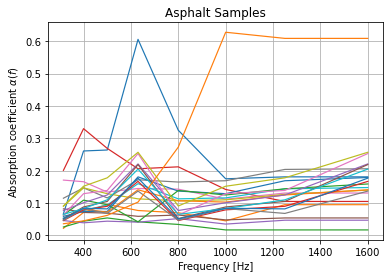

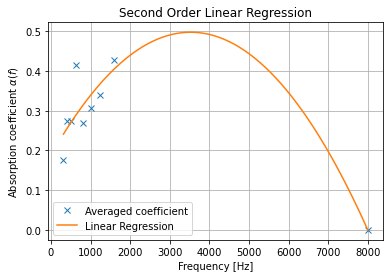

Frequencies:  [   0.    571.43 1142.86 1714.29 2285.71 2857.14 3428.57 4000.  ]
Absorption Coefficients:  [0.19 0.28 0.36 0.42 0.46 0.49 0.5  0.49]


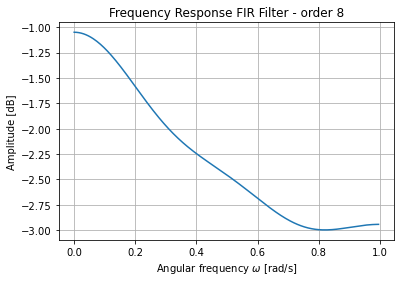

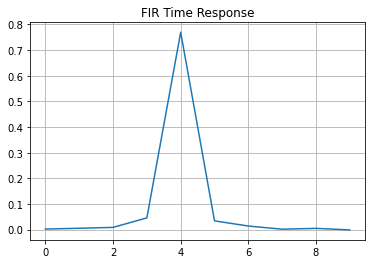

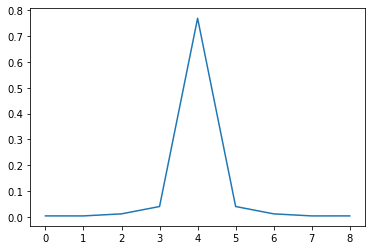

In [20]:
f = np.array([315, 400, 500, 630, 800, 1000, 1250, 1600])
m1 = np.array([0.067, 0.261, 0.264, 0.606, 0.325, 0.175, 0.181, 0.181])
m2 = np.array([0.022, 0.071, 0.096, 0.077, 0.070, 0.045, 0.095, 0.095])
m3 = np.array([0.026, 0.044, 0.054, 0.042, 0.034, 0.017, 0.017, 0.017])
m4 = np.array([0.201, 0.330, 0.269, 0.206, 0.212, 0.142, 0.105, 0.105])

p1 = np.array([0.046, 0.039, 0.044, 0.041, 0.052, 0.035, 0.047, 0.047])
p2 = np.array([0.036, 0.045, 0.062, 0.103, 0.273, 0.628, 0.609, 0.609])
p3 = np.array([0.082, 0.071, 0.069, 0.059, 0.063, 0.048, 0.054, 0.054])
p4 = np.array([0.171, 0.166, 0.134, 0.145, 0.143, 0.112, 0.131, 0.131])

tino1 = np.array([0.115, 0.147, 0.116, 0.172, 0.165, 0.169, 0.204, 0.206])
tino2 = np.array([0.09, 0.147, 0.129, 0.113, 0.107, 0.110, 0.127, 0.140])

anas5old1 = np.array([0.054, 0.077, 0.094, 0.16, 0.113, 0.116, 0.144, 0.148])
anas5p1 = np.array([0.047, 0.064, 0.043, 0.116, 0.091, 0.082, 0.100, 0.107])
anas15 = np.array([0.052, 0.062, 0.056, 0.111, 0.093, 0.100, 0.134, 0.140])
anas0old2 = np.array([0.059, 0.074, 0.074, 0.181, 0.137, 0.129, 0.169, 0.179])
anas0p2 = np.array([0.049, 0.081, 0.072, 0.141, 0.107, 0.103, 0.125, 0.141])
anas10 = np.array([0.063, 0.109, 0.095, 0.042, 0.139, 0.125, 0.144, 0.159])
iso103p = np.array([0.046, 0.079, 0.090, 0.167, 0.046, 0.079, 0.090, 0.167])
iso103 = np.array([0.077, 0.101, 0.125, 0.221, 0.077, 0.101, 0.125, 0.221])
isoAE4p = np.array([0.052, 0.088, 0.105, 0.219, 0.052, 0.088, 0.105, 0.219])
isoAE4 = np.array([0.063, 0.129, 0.139, 0.253, 0.063, 0.129, 0.139, 0.253])
disc5 = np.array([0.047, 0.083, 0.068, 0.137, 0.047, 0.083, 0.068, 0.137])
cont6les = np.array([0.091, 0.152, 0.178, 0.257, 0.091, 0.152, 0.178, 0.257])
cont6 = np.array([0.065, 0.083, 0.110, 0.205, 0.065, 0.083, 0.110, 0.205])
disc7 = np.array([0.051, 0.084, 0.082, 0.177, 0.051, 0.084, 0.082, 0.177])
asphalts2 = np.matrix([m1, m2, m3, m4, p1, p3, p4, tino1, tino2, anas5old1, anas0old2,
    anas0p2, anas10, iso103p, iso103, isoAE4p, isoAE4, disc5, cont6les,
    cont6, disc7, p2])

plt.figure()
plt.plot(f, asphalts2.T, linewidth = 1.2)
plt.title('Asphalt Samples')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Absorption coefficient $\alpha(f)$')
plt.grid()
plt.show()

asphalts2 = np.c_[asphalts2, np.zeros(np.shape(asphalts2)[0])]
f = np.append(f, 8000)

# Compute average coefficients
alpha_avg = np.asarray(np.sum(asphalts2, axis = 0)).flatten() / np.shape(asphalts2)[1]
model_alpha2 = np.polyfit(f, alpha_avg, deg = 2)

f1 = np.linspace(315, 8000, num = 100)
estimated_asphalts = np.polyval(model_alpha2, f1)

plt.figure()
plt.plot(f, alpha_avg, 'x', linewidth = 1.1)
plt.plot()
plt.plot(f1, estimated_asphalts, linewidth = 1.5)
plt.title('Second Order Linear Regression')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Absorption coefficient $\alpha(f)$')
plt.legend(['Averaged coefficient', 'Linear Regression'])
plt.grid()
plt.show()

f_nyq = 4000
f_sel = np.linspace(0,1,8) * f_nyq
alpha_sel = np.polyval(model_alpha2, f_sel)

print('Frequencies: ', np.around(f_sel, 2))
print('Absorption Coefficients: ', np.around(alpha_sel, 2))

numtaps_asphalt = 9
filter_len = 256

refl = np.sqrt(1 - alpha_sel)
b_fir = scipy.signal.firls(numtaps_asphalt, f_sel / 4000, refl)

w, H_fir = scipy.signal.freqz(b_fir, a=1, worN = filter_len)
H_fir_full = np.concatenate((H_fir, H_fir[-1:0:-1].conj()))

h_fir = np.fft.ifft(H_fir_full).real

plt.figure()
plt.plot(w/np.pi, 20 * np.log10(abs(H_fir)))
plt.title('Frequency Response FIR Filter - order %d' %(numtaps_asphalt - 1))
plt.xlabel(r"Angular frequency $\omega$ [rad/s]")
plt.ylabel("Amplitude [dB]")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.concatenate((h_fir, np.zeros(512 - len(h_fir))))[0:10])
plt.title('FIR Time Response')
plt.grid()
plt.show()

plt.figure()
plt.plot(b_fir)


theta_vector = np.arange(-89,89,1)
Z0 = compute_air_impedance(20 + 273.15)
c = compute_speed_sound(20 + 273.15)
Z = - Z0 * (refl + 1) / (refl-1)
filter_len = 20
filters = np.zeros((len(theta_vector),filter_len, 1))
b_fir = np.zeros((len(theta_vector), numtaps_asphalt))
H_fir = np.zeros((len(theta_vector), numtaps_asphalt), dtype = np.complex_)

# Compute filters coefficients for all thetas
for idx, theta in enumerate(theta_vector):
    R = ((Z * np.cos(math.radians(theta)) - Z0) / (Z * np.cos(math.radians(theta)) + Z0))
    # b_fir = scipy.signal.firls(numtaps, f_sel / 4000, R)      # Exception 'Desired must be positive'
    b_fir[idx] = scipy.signal.firwin2(numtaps_asphalt, f_sel / 4000, R)
    # time, imp_resp1 = scipy.signal.dimpulse((b_fir[idx], np.concatenate((np.array([1.]), np.zeros(len(b_fir[idx])-1))), 1), n=filter_len)
    # filters[idx] = imp_resp1[0]
    w, H_fir[idx] = scipy.signal.freqz(b_fir[idx], a=1, worN = numtaps_asphalt)

def compute_asphalt_reflection_filter(theta, b_fir, theta_vector):
    idx = np.where(theta_vector == np.round(theta))
    idx = idx[0][0]
    return b_fir[idx]
    
    

In [21]:
fs = 8000
# Straight Trajectory between starting and end point
P1 = np.array([3,10])
P2 = np.array([3, -5])
P3 = np.array([0,0])

# Assume source and receiver lie on the same plane above the ground
height = 1
v = 5   # speed of sound source

# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj_init = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj_init ** 2 + dline ** 2)

# Compute initial distance from first reflection to MIC
dinit_refl = np.sqrt(dinit ** 2 + (2 * height) ** 2)

# Compute time delays in number of samples
c = 343
tau_init = dinit / c
tau_init_refl = dinit_refl / c

M_init = tau_init * fs
M_init_refl = tau_init_refl * fs

print('Initial delay in samples - direct: %f' %M_init)
print('Initial delay in samples - reflected: %f' %(M_init_refl / 2))

delays_sec = []
delays_sec_refl = []

delays_sec.append(tau_init)
delays_sec_refl.append(tau_init_refl)


# Define delay lines
N = 48000
A = np.zeros(N)         # Primary Delay Line
B = np.zeros_like(A)    # Secondary Delay Line for reflected path


rptrAdir = 0
rptrArefl = 0
rptrB = 0

wptrA = 0
wptrB = 0

M1 = np.floor(M_init)    # Define initial delay
M3 = np.floor(M_init_refl / 2)  # initial Delay for Secondary Delay Line

dproj = dproj_init
# dproj_refl = dproj / 2

# Set Delays on Primary Delay Line
def set_delay(M1, M2):
    global rptrAdir
    global rptrArefl

    rptrAdir = wptrA - M1
    rptrArefl = wptrA - M2
    if (rptrAdir < 0):
        rptrAdir += N
    if (rptrArefl < 0):
        rptrArefl += N

# Set Delay on Secondary Delay Line
def set_delay_secondary(M):
    global rptrB
    rptrB = wptrB - M
    if (rptrB < 0):
        rptrB += N

def delay_lineA(x):
    global rptrAdir
    global rptrArefl
    global wptrA
    global A
    global v
    global dproj
    global c
    global fs
    global delays_sec
    global delays_sec_refl
    
    A[wptrA] = x
    wptrA += 1

    rpi = math.floor(rptrAdir)
    a = rptrAdir - rpi
    ydir = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    rpi = math.floor(rptrArefl)
    a = rptrArefl - rpi
    yrefl = a * A[rpi + 1] + (1 - a) * A[rpi]

    
    # Update delay
    dproj -= v / fs
    # dproj_refl = dproj / 2
    d2 = dline2 + dproj ** 2
    d = np.sqrt(d2)
    drefl2 = d2 + (2 * height) ** 2
    drefl = np.sqrt(drefl2)
    # angle of incidence
    cos_theta = d / drefl
    theta = math.degrees(math.acos(cos_theta))
    drefl = drefl / 2

    tau = d / c
    tau_refl = drefl / c
    M1 = tau * fs
    M2 = tau_refl * fs
    rptrAdir = wptrA - M1
    rptrArefl = wptrA - M2
    
    if (rptrAdir < 0):
        rptrAdir += N
    if (rptrArefl < 0):
        rptrArefl += N
    if (wptrA >= N - 1):
        wptrA -= (N)
    if (rptrAdir >= N - 1):
        rptrAdir -= (N)
    if (rptrArefl >= N - 1):
        rptrArefl -= (N)
    return ydir, yrefl, d, drefl, theta

def delay_lineB(x, drefl):
    global rptrB
    global wptrB
    global B
    global v
    global c
    global fs
    global delays_smp
    
    B[wptrB] = x
    wptrB += 1

    rpi = math.floor(rptrB)
    a = rptrB - rpi
    # Linear Interpolation
    y1 = a * B[rpi + 1] + (1 - a) * B[rpi]
    
    # Sinc Interpolation -> Windowed Sinc function
    # h_sinc = frac_delay_sinc(a)
    
    # y2 = 0
    # for i in range(0, sinc_samples):
    #     y2 = y2 + h_sinc[i]*A[np.mod(rpi + i - math.floor(sinc_samples/2), len(A))]
    
    # # Lagrange Interpolation
    # order = 5
    # h_lagrange = frac_delay_lagrange(order, a)
    # y3 = 0

    # for i in range(0, len(h_lagrange)):
    #     y3 = y3 + h_lagrange[i] * A[np.mod(rpi + i, len(A))]

    # Update delay
    # dproj_refl -= v / fs
    
    # d2 = dline2 + dproj_refl ** 2
    # d = np.sqrt(d2)
    tau = drefl / c
    M = tau * fs
    rptrB = wptrB - M

    if (rptrB < 0):
        rptrB += N
    if (wptrB >= N - 1):
        wptrB -= (N)
    if (rptrB >= N - 1):
        rptrB -= (N)

    return y1, d


set_delay(M1, M3)
set_delay_secondary(M3)

a = 0
signal = 0

## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
# signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
signal = np.zeros_like(time)
signal[::100] = 1

aa = np.zeros_like(signal)
bb = np.zeros_like(signal)
cc = np.zeros_like(signal)
dd = np.zeros_like(signal)
ee = np.zeros_like(signal)
ff = np.zeros_like(signal)
gg = np.zeros_like(signal)
receivedSignal = np.zeros_like(signal)

# Full Path Implementation
for i in range(0, len(signal)):
    # Delay passage
    [ydir, yrefl, ddir, drefl, theta] = delay_lineA(signal[i])

    ## DIRECT COMPONENT
    
    # Attenuation due to distance
    att = sound_attenuation_distance(ddir)
    aa[i] =  1 * ydir

    # Attenuation due to air absorption
    alpha = compute_air_absorption_coeffs(T, p_s, hrar, F)
    alpha = 10 ** (-alpha * ddir / 20)     # Convert coeffs in dB to linear scale
    filt_coeffs = compute_air_absorption_filter(F, alpha, numtaps_airabs)
    
    sample_eval = 0
    for ii in range(numtaps_airabs):
        sample_eval = sample_eval + aa[i - ii] * filt_coeffs[ii]
    bb[i] = sample_eval
    # bb[i] = aa[i]
    ## REFLECTED COMPONENT

    # 1. From Source to Road Surface
    
    # Attenuation due to distance
    att = sound_attenuation_distance(drefl)
    cc[i] = 1 * yrefl

    # Attenuation due to air absorption
    alpha = compute_air_absorption_coeffs(T, p_s, hrar, F)
    alpha = 10 ** (-alpha * drefl / 20)     # Convert coeffs in dB to linear scale
    filt_coeffs = compute_air_absorption_filter(F, alpha, numtaps_airabs)

    sample_eval = 0
    for ii in range(numtaps_airabs):
        sample_eval = sample_eval + cc[i - ii] * filt_coeffs[ii]
    dd[i] = sample_eval
    # dd[i] = cc[i]

    # 2. Asphalt Absorption
    asphalt_filter_coeffs = compute_asphalt_reflection_filter(90 - theta, b_fir, theta_vector)
    sample_eval = 0
    for ii in range(numtaps_asphalt):
        sample_eval = sample_eval + dd[i - ii] * asphalt_filter_coeffs[ii]
    ee[i] = sample_eval
    # ee[i] = dd[i]
    # 3. Second path in air --> Delay Line B
    y, d = delay_lineB(ee[i], drefl)

    # 4. From Road Surface to Receiver

    # Attenuation due to distance
    att = sound_attenuation_distance(d)
    ff[i] = 1 * y

    # Attenuation due to air absorption
    # alpha = compute_air_absorption_coeffs(T, p_s, hrar, F)
    # alpha = 10 ** (-alpha * drefl / 20)     # Convert coeffs in dB to linear scale
    # filt_coeffs = compute_air_absorption_filter(F, alpha, numtaps_airabs)

    sample_eval = 0
    for ii in range(numtaps_airabs):
        sample_eval = sample_eval + ff[i - ii] * filt_coeffs[ii]
    gg[i] = sample_eval
    # gg[i] = ff[i]

    receivedSignal[i] = bb[i] + gg[i]



Initial delay in samples - direct: 243.505691
Initial delay in samples - reflected: 123.966715


Text(0, 0.5, 'Frequency [Hz]')

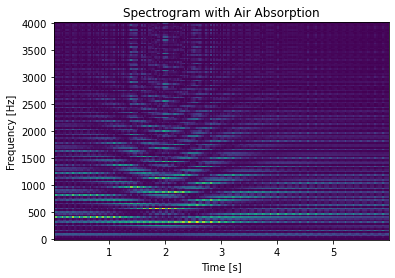

In [22]:
plt.figure()
# plt.subplot(1,2,1)
ff, tt, Sxx = scipy.signal.spectrogram(receivedSignal, fs)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram with Air Absorption')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

# plt.subplot(1,2,2)
# ff, tt, Sxx = scipy.signal.spectrogram(aa, fs)
# plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
# plt.title('Spectrogram without Air Absorption')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.subplots_adjust(left=0.125, right=1.5)
